In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import matplotlib
import matplotlib.patheffects as path_effects
import seaborn as sns
import scipy

colors = ["#FFE599", "#CF597E", "#C3ABD0", "#B9E0A5", "#089099"]# Set your custom color palette
color_map = list(map(lambda x: sns.desaturate(x,0.9),colors))
sns.set_palette(color_map)
sns.color_palette() 


[(0.98, 0.8882352941176471, 0.6200000000000001),
 (0.7886274509803921, 0.37215686274509796, 0.5027450980392157),
 (0.7625490196078432, 0.677843137254902, 0.8084313725490196),
 (0.7292156862745098, 0.8668627450980392, 0.6586274509803921),
 (0.05980392156862746, 0.5398039215686272, 0.5715686274509804)]

In [2]:


def PARALia_log_read(filename):
    temp = pd.read_csv(filename, header=None, names = ['T','dev_num', 'dev_id_token', 'cachesize_limit','TransA','TransB',
                                                    'alpha','beta','M','N','K','Asloc','Bsloc','Csloc', 'CsOutloc', 'timer', 'pred_t', 'pred_J'], 
                                                     dtype = {'M': np.int64, 'N': np.int64, 'K': np.int64, 'timer': np.float64, 'pred_t': np.float64, 'pred_J': np.float64} )
    temp.sort_values(by=['M','N','K'])
    return temp

def keep_dev_num(num, dataframe):
    return dataframe[dataframe['dev_num'] == num]

machine = 'karol'
homedir = '~/karol_results_06-04-2024/'
devices = 8
#Mmax = ?
#MemMax = 28*(1024*1024*1024) # Questionable limit
Rmax_Gflops = 15*1024*devices
dev_W_avg = 400

dataset = pd.DataFrame()
ctr = 0 

ctr += 1 ################
scenario_name="cuBLASXt-malloc"
version="2.99"
cuBLASXt_malloc = (PARALia_log_read('%s/cuBLASXtDgemmRunner_predefined_vals_%s.log' 
    %(homedir + 'PARALiA-GEMMex-qeta-mineta-auto-malloc_testLogs', version)))
cuBLASXt = (PARALia_log_read('%s/cuBLASXtDgemmRunner_predefined_vals_%s.log' 
    %(homedir + 'PARALiA-GEMMex-cuBLASXt-bench_testLogs', version)))
print('cuBLASXt len: %d\n' % len(cuBLASXt))
cuBLASXt_onlydev = cuBLASXt[(cuBLASXt['Asloc'] < 8) & (cuBLASXt['Bsloc'] < 8) & (cuBLASXt['Csloc'] < 8)]
cuBLASXt_malloc = pd.concat([cuBLASXt_malloc, cuBLASXt_onlydev])
print('cuBLASXt_malloc len: %d\n' % len(cuBLASXt_malloc))
cuBLASXt_malloc['imp'] = scenario_name
cuBLASXt_malloc['plot_order'] = ctr
dataset = pd.concat([dataset,cuBLASXt_malloc])

ctr += 1 ################
scenario_name="cuBLASXt"
version="2.99"
cuBLASXt['imp'] = scenario_name
cuBLASXt['plot_order'] = ctr
dataset = pd.concat([dataset,cuBLASXt])
cuBLASXt_based = cuBLASXt
cuBLASXt_based['imp'] = scenario_name + '-based'
cuBLASXt_based['timer'][(cuBLASXt_based['Asloc'] == 0)] = cuBLASXt_based['timer']/4
dataset = pd.concat([dataset,cuBLASXt_based])

ctr += 1 ################
XKBLAS_malloc_allin = (PARALia_log_read('%s/XKBLAS_dgemm_runner_0.4_1600.log' %(homedir + 'xkblas-v0.4-bare-1600_testLogs')))

XKBLAS_malloc_dev = XKBLAS_malloc_allin[(XKBLAS_malloc_allin['Asloc'] < 8) & (XKBLAS_malloc_allin['Bsloc'] < 8) & (XKBLAS_malloc_allin['Csloc'] < 8)]
XKBLAS_malloc_interish = (PARALia_log_read('%s/XKBLAS_dgemm_runner_0.4_1600_interhost.log' %(homedir + 'xkblas-v0.4-bare-1600_testLogs')))
scenario_name="XKBLAS"
XKBLAS_malloc_interish['Asloc'][XKBLAS_malloc_interish['Asloc'] == 8] = 9
XKBLAS_malloc_interish['Bsloc'][XKBLAS_malloc_interish['Bsloc'] == 8] = 9
XKBLAS_malloc_interish['Csloc'][XKBLAS_malloc_interish['Csloc'] == 8] = 9
XKBLAS_inter = pd.concat([XKBLAS_malloc_interish,XKBLAS_malloc_dev]) 
print('XKBLAS_inter len: %d\n' % len(XKBLAS_inter))
XKBLAS_inter['imp'] = scenario_name
XKBLAS_inter['plot_order'] = ctr
dataset = pd.concat([dataset,XKBLAS_inter])

ctr += 1 ################
scenario_name="taco-paralia-1.5-fixed-streams"
PARALiA15_taco_fixed = (PARALia_log_read('%s/CoCoPeLiaDgemmRunner_predefined_vals_ST-2D-BLOCK-CYCLIC__UN-PB-L8_ALL-HOPS-1-0.20_PW-PRED-PERF_1.5.log' 
    %(homedir + 'PARALiA-Framework-1.5_testLogs')))
print('PARALiA15_taco_fixed len: %d\n' % len(PARALiA15_taco_fixed))
PARALiA15_taco_fixed['imp'] = scenario_name
PARALiA15_taco_fixed['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA15_taco_fixed])

ctr += 1 ################
scenario_name="naive"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO-BASIC"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-P2P-INIT"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-SERIAL"
pw_optimize="PW-PRED-PERF"
version="2.99"
PARALiA2_naive = (PARALia_log_read('%s/dgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s.log' 
    %(homedir + 'PARALiA-GEMMex-' + scenario_name + '_testLogs', 
    comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, version)))
print('PARALiA2_naive len: %d\n' % len(PARALiA2_naive))
PARALiA2_naive['imp'] = scenario_name
PARALiA2_naive['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA2_naive])

ctr += 1 ################
scenario_name="distance"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO-BASIC"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-P2P-DISTANCE"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-SERIAL"
pw_optimize="PW-PRED-PERF"
version="2.99"
PARALiA2_distance = (PARALia_log_read('%s/dgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s.log' 
    %(homedir + 'PARALiA-GEMMex-' + scenario_name + '_testLogs', 
    comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, version)))
print('PARALiA2_distance len: %d\n' % len(PARALiA2_distance))
PARALiA2_distance['imp'] = scenario_name
PARALiA2_distance['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA2_distance])

ctr += 1 ##################
scenario_name="qeta"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO-BASIC"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-CHAIN-QETA"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-SERIAL"
pw_optimize="PW-PRED-PERF"
version="2.99"
PARALiA2_chain_qeta = (PARALia_log_read('%s/dgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s.log' 
    %(homedir + 'PARALiA-GEMMex-' + scenario_name + '_testLogs', 
    comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, version)))
print('PARALiA2_chain_qeta len: %d\n' % len(PARALiA2_chain_qeta))
PARALiA2_chain_qeta['imp'] = scenario_name
PARALiA2_chain_qeta['plot_order'] = ctr
PARALiA2_chain_qeta['timer'][PARALiA2_chain_qeta['timer'] < 0.1] = PARALiA2_chain_qeta['timer']*0.95
dataset = pd.concat([dataset,PARALiA2_chain_qeta])

ctr += 1 ##################
scenario_name="qeta-mineta-auto"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO_AUTO"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-CHAIN-QETA"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-QETA"
pw_optimize="PW-PRED-PERF"
version="2.99"
PARALiA2_chain_qeta_mineta_auto = (PARALia_log_read('%s/dgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s.log' 
    %(homedir + 'PARALiA-GEMMex-' + scenario_name + '_testLogs', 
    comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, version)))
print('PARALiA2_chain_qeta_mineta_auto len: %d\n' % len(PARALiA2_chain_qeta_mineta_auto))
PARALiA2_chain_qeta_mineta_auto['imp'] = scenario_name
PARALiA2_chain_qeta_mineta_auto['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA2_chain_qeta_mineta_auto])

ctr += 1 ##################
scenario_name="qeta-mineta-auto-reptile-fastev"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO_AUTO"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-CHAIN-QETA"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-QETA"
pw_optimize="PW-PRED-PERF"
reptile="REPTILE-5"
version="2.99"
PARALiA2_chain_qeta_mineta_auto_reptile_fastev = (PARALia_log_read('%s/dgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s_%s.log' 
    %(homedir + 'PARALiA-GEMMex-' + scenario_name + '_testLogs', 
    comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, reptile, version)))
print('PARALiA2_chain_qeta_mineta_auto_reptile_fastev len: %d\n' % len(PARALiA2_chain_qeta_mineta_auto_reptile_fastev))
PARALiA2_chain_qeta_mineta_auto_reptile_fastev['imp'] = scenario_name
PARALiA2_chain_qeta_mineta_auto_reptile_fastev['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA2_chain_qeta_mineta_auto_reptile_fastev])

ctr += 1 ################
scenario_name="cuBLASXt-float"
version="2.99"
cuBLASXt_float = (PARALia_log_read('%s/cuBLASXtSgemmRunner_predefined_vals_%s.log' 
    %(homedir + 'PARALiA-GEMMex-qeta-mineta-auto-reptile-float_testLogs', version)))
print('cuBLASXt len: %d\n' % len(cuBLASXt_float))
cuBLASXt_float['imp'] = scenario_name
cuBLASXt_float['plot_order'] = ctr
dataset = pd.concat([dataset,cuBLASXt_float])

ctr += 1 ################
XKBLAS_allin_float = (PARALia_log_read('%s/XKBLAS_sgemm_runner_0.4_1600_interhost.log' %(homedir + 'xkblas-v0.4-bare-1600_testLogs')))
scenario_name="XKBLAS-float"
XKBLAS_allin_float['Asloc'][XKBLAS_allin_float['Asloc'] == 8] = 9
XKBLAS_allin_float['Bsloc'][XKBLAS_allin_float['Bsloc'] == 8] = 9
XKBLAS_allin_float['Csloc'][XKBLAS_allin_float['Csloc'] == 8] = 9
print('XKBLAS_allin_float len: %d\n' % len(XKBLAS_allin_float))
XKBLAS_allin_float['imp'] = scenario_name
XKBLAS_allin_float['plot_order'] = ctr
dataset = pd.concat([dataset,XKBLAS_allin_float])

ctr += 1 ################
scenario_name="taco-paralia-1.5-fixed-streams-float"
PARALiA15_taco_fixed_float = (PARALia_log_read('%s/CoCoPeLiaSgemmRunner_predefined_vals_ST-2D-BLOCK-CYCLIC__UN-PB-L8_ALL-HOPS-1-0.20_PW-PRED-PERF_1.5.log' 
    %(homedir + 'PARALiA-Framework-1.5_testLogs')))
print('PARALiA15_taco_fixed_float len: %d\n' % len(PARALiA15_taco_fixed_float))
PARALiA15_taco_fixed_float['imp'] = scenario_name
PARALiA15_taco_fixed_float['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA15_taco_fixed_float])

ctr += 1 ##################
scenario_name="qeta-mineta-auto-reptile-float"
comp_streams="COMP_STREAMS_PERDEV-8"
streaming_overlap="COMM_STREAM_BUFFERING-8"
algo="ALGO_AUTO"
account_for_tile_sl="_MODEL-TILE-SL"
distribution="2D-BLOCK-CYCLIC-D1_lesseq_D2"
fetch_routing="FETCH-CHAIN-QETA"
wb_routing="WB-P2P-INIT"
task_order="TASK-ORDER-QETA"
pw_optimize="PW-PRED-PERF"
reptile="REPTILE-5"
version="2.99"
PARALiA2_chain_qeta_mineta_auto_reptile_float = (PARALia_log_read('%s/sgemm_runner_predefined_vals__%s_%s_%s%s_%s_%s_%s_%s_%s_%s_%s.log' 
    %(homedir + 'PARALiA-GEMMex-' + scenario_name + '_testLogs', 
    comp_streams, streaming_overlap, algo, account_for_tile_sl, distribution, fetch_routing, wb_routing, task_order, pw_optimize, reptile, version)))
print('PARALiA2_chain_qeta_mineta_auto_reptile_float len: %d\n' % len(PARALiA2_chain_qeta_mineta_auto_reptile_float))
PARALiA2_chain_qeta_mineta_auto_reptile_float['imp'] = scenario_name
PARALiA2_chain_qeta_mineta_auto_reptile_float['plot_order'] = ctr
dataset = pd.concat([dataset,PARALiA2_chain_qeta_mineta_auto_reptile_float])


cuBLASXt len: 3150

cuBLASXt_malloc len: 3150

XKBLAS_inter len: 2690

PARALiA15_taco_fixed len: 3080

PARALiA2_naive len: 3150

PARALiA2_distance len: 3150

PARALiA2_chain_qeta len: 3150

PARALiA2_chain_qeta_mineta_auto len: 3150

PARALiA2_chain_qeta_mineta_auto_reptile_fastev len: 34650

cuBLASXt len: 28682

XKBLAS_allin_float len: 2750

PARALiA15_taco_fixed_float len: 3150

PARALiA2_chain_qeta_mineta_auto_reptile_float len: 28690



In [3]:
def PARALiA_grouby_avg(df):
    result = df.groupby(['dev_num', 'dev_id_token', 'cachesize_limit','TransA','TransB',
        'alpha','beta','M','N','K','Asloc','Bsloc','Csloc', 'CsOutloc', 'flops', 'bytes', 'loc_str', 'imp', 'plot_order'], as_index=False, sort=True).mean()
    #print(result)
    return result

def PARALiA_grouby_max(df):
    result = df.groupby(['T','dev_num', 'dev_id_token', 'cachesize_limit','TransA','TransB',
        'alpha','beta','M','N','K','Asloc','Bsloc','Csloc', 'CsOutloc', 'flops', 'bytes', 'loc_str', 'imp', 'plot_order'], as_index=False, sort=True).max()
    #print(result)
    return result

def PARALiA_select_subset(df, subset_str):
    if subset_str == 'square': 
        return df.loc[(df['M'] == df['N']) & (df['M'] == df['K'])]
    elif subset_str == 'fat-thin':
        return df.loc[(df['M'] == df['N']) & (df['M'] > df['K'])]
    elif subset_str == 'thin-fat':        
        return df.loc[(df['M'] == df['N']) & (df['M'] < df['K'])]
    
def PARALiA_select_indata_locs(df, loc1, loc2, loc3):
    return df.loc[(df['Asloc'] == loc1) & (df['Bsloc'] == loc2) & (df['Csloc'] == loc3)]

def dgemm_flops(df):
    df['flops'] = df['M']*df['N']*(2*df['K'] + 2)
    return df['M']*df['N']*(2*df['K'] + 2)
def dgemm_bytes(df):
    df['bytes'] = 8*(df['M']*(df['N']+df['K']) + df['N']*df['K']) 
    return 8*(df['M']*(df['N']+df['K']) + df['N']*df['K']) 

def add_median_labels(ax: plt.Axes, offset: int, fmt: str = "d") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y + offset, f'{int(value):{fmt}}', ha='center', va='center',
                       color='white', fontsize = font-1) #fontweight='bold', 
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground=median.get_color()),
            path_effects.Normal(),
        ])

In [4]:
font=8
#plt.rc('font', family='serif', serif='Times') #annoying warning filling my view, so disabled until needed
#plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=font)
plt.rc('ytick', labelsize=font)
plt.rc('axes', labelsize=font)
plt.rc('figure', titlesize=font)
# width as measured in inkscape
width = 3.487
height = width / 1.618

#fig, ax = plt.subplots()
#fig.subplots_adjust(left=.15, bottom=.17, right=.99, top=.97)

In [5]:
dgemm_bytes(dataset)
dgemm_flops(dataset)
dataset['pred_t'] = dataset['pred_J'] = 0
dataset['perf'] = dataset['flops']/(1e9*dataset['timer'])
dataset['energy'] = dataset['timer']*(dev_W_avg* dataset['dev_num'])
dataset['EDP'] = (dataset['perf'])*(dataset['perf'])/(dev_W_avg* dataset['dev_num'])
dataset['PDP'] = dataset['flops']/(1e9*dataset['energy'])
dataset['Asloc'][dataset['Asloc'] == 12] = -1
dataset['Bsloc'][dataset['Bsloc'] == 12] = -1
dataset['Csloc'][dataset['Csloc'] == 12] = -1
dataset['Asloc'][dataset['Asloc'] == 9] = -1
dataset['Bsloc'][dataset['Bsloc'] == 9] = -1
dataset['Csloc'][dataset['Csloc'] == 9] = -1
dataset['Asloc'][dataset['Asloc'] == 8] = -2
dataset['Bsloc'][dataset['Bsloc'] == 8] = -2
dataset['Csloc'][dataset['Csloc'] == 8] = -2
#dataset['Asloc'][dataset['Asloc'] == -2] = -1
#dataset['Bsloc'][dataset['Bsloc'] == -2] = -1
#dataset['Csloc'][dataset['Csloc'] == -2] = -1
dataset['loc_str'] = 100*(dataset['Csloc']+1) + 10*(dataset['Bsloc']+1) + dataset['Asloc']+1
for imp in dataset['imp'].unique().tolist():
    temp_dataset = dataset[dataset['imp'] == imp]
    print("Implementation %s : mean of %d cases -> perf = (ar = %.2lf, ar/ar = %.2lf, geomean = %.2lf, harmonic = %.2lf) Tflops/s, Energy = %lf J, PDP = %lf, EDP = %lf" % 
        (imp, len(PARALiA_grouby_avg(temp_dataset)),
        PARALiA_grouby_avg(temp_dataset)['perf'].mean()/1e3,
        PARALiA_grouby_avg(temp_dataset)['flops'].mean()/PARALiA_grouby_avg(temp_dataset)['timer'].mean()/1e12,
        scipy.stats.mstats.gmean(PARALiA_grouby_avg(temp_dataset).loc[:,'perf'])/1e3, 
        scipy.stats.hmean(PARALiA_grouby_avg(temp_dataset).loc[:,'perf'])/1e3,
        PARALiA_grouby_avg(temp_dataset)['energy'].mean(), PARALiA_grouby_avg(temp_dataset)['PDP'].mean(),  PARALiA_grouby_avg(temp_dataset)['EDP'].mean()))

Implementation cuBLASXt-malloc : mean of 315 cases -> perf = (ar = 9.63, ar/ar = 10.17, geomean = 6.72, harmonic = 3.34) Tflops/s, Energy = 3788.080697 J, PDP = 3.009780, EDP = 43297.625314
Implementation cuBLASXt : mean of 315 cases -> perf = (ar = 11.27, ar/ar = 11.57, geomean = 7.60, harmonic = 3.55) Tflops/s, Energy = 3328.880116 J, PDP = 3.521604, EDP = 64011.819158
Implementation cuBLASXt-based : mean of 315 cases -> perf = (ar = 17.97, ar/ar = 13.15, geomean = 10.03, harmonic = 4.08) Tflops/s, Energy = 2929.811590 J, PDP = 5.616649, EDP = 215943.453431
Implementation XKBLAS : mean of 269 cases -> perf = (ar = 66.88, ar/ar = 66.09, geomean = 54.49, harmonic = 37.78) Tflops/s, Energy = 539.637683 J, PDP = 20.900197, EDP = 1754492.366981
Implementation taco-paralia-1.5-fixed-streams : mean of 308 cases -> perf = (ar = 69.13, ar/ar = 79.39, geomean = 60.91, harmonic = 50.91) Tflops/s, Energy = 454.995083 J, PDP = 21.603868, EDP = 1785780.434348
Implementation naive : mean of 315 cas

/tmp/ipykernel_5366/1163005388.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['All-data-CPU(h,h,h)','All-data-GPU(0,0,0)']) #'Output-GPU(h,h,0)', 'Input-GPU(4,2,h)',  'All-data-GPU(0,1,2)','All-data-GPU(0,3,6)', ,  'All-data-GPUs(4,2,7)'


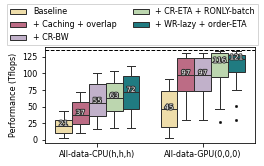

In [6]:
def enforce_dataset_limits_imp(df):
    return df[
    ((df['M']*df['N']*df['K'] >=  4096**3)) & #((df['M'] >= 1024)) & ((df['N'] >= 1024)) & ((df['K'] >= 1024)) & 
    (df['M'] == df['N']) & (df['K'] == df['M']) &
    #((df['Asloc'] == -1) |
    (((df['Asloc'] == -1) & (df['Csloc'] == -1)) |
    ((df['Asloc'] == 0) & (df['Bsloc'] == 0) & (df['Csloc'] == 0))) ]

#sns.set_palette("flare")
sns.set_palette(color_map)
#sns.color_palette()

dataset_imp_comparisson = dataset[
                        (dataset['imp'] == 'cuBLASXt-based') |
                        (dataset['imp'] == 'naive') |
                        (dataset['imp'] == 'distance') |
                        (dataset['imp'] == 'qeta') |
                        #(dataset['imp'] == 'taco-paralia-1.5-malloc') |
                        #(dataset['imp'] == 'qeta-mineta') |
                        #(dataset['imp'] == 'qeta-mineta-wrlazy') |
                        #(dataset['imp'] == 'qeta-mineta-auto') |
                        #(dataset['imp'] == 'qeta-auto-reptile') |
                        #(dataset['imp'] == 'qeta-minfetch-auto-reptile') |
                        #(dataset['imp'] == 'qeta-mineta-auto-reptile')|
                        (dataset['imp'] == 'qeta-mineta-auto-reptile-fastev')]
dataset_imp_comparisson['imp'][dataset_imp_comparisson['imp'] == 'cuBLASXt-based'] = 'Baseline'
dataset_imp_comparisson['imp'][dataset_imp_comparisson['imp'] == 'naive'] = '+ Caching + overlap'
dataset_imp_comparisson['imp'][dataset_imp_comparisson['imp'] == 'distance'] = '+ CR-BW'
dataset_imp_comparisson['imp'][dataset_imp_comparisson['imp'] == 'qeta'] = '+ CR-ETA + RONLY-batch'
#dataset_imp_comparisson['imp'][dataset_imp_comparisson['imp'] == 'qeta-mineta-auto'] = 'ETA-bcast + LAZY WR'
dataset_imp_comparisson['imp'][dataset_imp_comparisson['imp'] == 'qeta-mineta-auto-reptile-fastev'] = '+ WR-lazy + order-ETA'

dataset_part_mean = enforce_dataset_limits_imp(PARALiA_grouby_avg(dataset_imp_comparisson))
dataset_part_mean['Performance (Tflops)'] = dataset_part_mean['perf']/1024
dataset_part_mean.sort_values(inplace = True, by = ['plot_order', 'loc_str'])
fig, ax = plt.subplots(1)
flierprops = dict(markerfacecolor='k', markersize=2,
              linestyle='none')
axout = sns.boxplot(data=dataset_part_mean, x = 'loc_str', y = 'Performance (Tflops)', hue = 'imp', ax=ax, flierprops=flierprops)
plt.axhline(y = 17*8, color = 'k', linestyle = '--', linewidth = 1) 
#ax.set_title('FP64 Square ( M = N = K)', size = font+1)
add_median_labels(axout, 3)
ax.set_xticklabels(['All-data-CPU(h,h,h)','All-data-GPU(0,0,0)']) #'Output-GPU(h,h,0)', 'Input-GPU(4,2,h)',  'All-data-GPU(0,1,2)','All-data-GPU(0,3,6)', ,  'All-data-GPUs(4,2,7)'
ax.set_xlabel('')
ax.get_legend().remove()
fig.legend(loc = 'upper center',#title="Model",  # Title for the legend
            fontsize=font, fancybox = False, ncol=2)
fig.set_size_inches(width, height)
fig.subplots_adjust(left=.15, bottom=.1, right=.99, top=.72)        
fig.savefig('Plots/Plot_testbed-%s_gflops_implementations_FP64.pdf' % (machine))
fig.savefig('Plots/Plot_testbed-%s_gflops_implementations_FP64.png' % (machine))

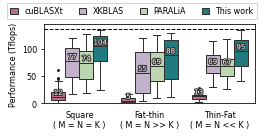

In [7]:
def enforce_dataset_limits(df):
    return df[((df['M']*df['N']*df['K'] >  4096**3))]

sns.set_palette(color_map[1:])
#sns.set_palette(cp3_2)
#sns.color_palette()

dataset_perf_comparisson = dataset[(dataset['imp'] == 'cuBLASXt') |
                        (dataset['imp'] == 'XKBLAS') |
                        #(dataset['imp'] == 'taco-paralia-1.5-malloc') |
                        (dataset['imp'] == 'taco-paralia-1.5-fixed-streams') |
                        #(dataset['imp'] == 'qeta-mineta-auto') |
                        #(dataset['imp'] == 'qeta-auto-reptile') |
                        #(dataset['imp'] == 'qeta-minfetch-auto-reptile')|
                        #dataset['imp'] == 'qeta-mineta-auto-reptile') |
                        (dataset['imp'] == 'qeta-mineta-auto-reptile-fastev')]
dataset_perf_comparisson['Asloc'][dataset_perf_comparisson['Asloc'] == -2] = -1
dataset_perf_comparisson['Bsloc'][dataset_perf_comparisson['Bsloc'] == -2] = -1
dataset_perf_comparisson['Csloc'][dataset_perf_comparisson['Csloc'] == -2] = -1
dataset_perf_comparisson['loc_str'] = 100*(dataset_perf_comparisson['Csloc']+1) + 10*(dataset_perf_comparisson['Bsloc']+1) + dataset_perf_comparisson['Asloc']+1
dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'taco-paralia-1.5-fixed-streams'] = 'PARALiA'
dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'qeta-mineta-auto-reptile-fastev'] = 'This work'

dataset_part_mean = enforce_dataset_limits(PARALiA_grouby_avg(dataset_perf_comparisson))
dataset_part_mean['Performance (Tflops)'] = dataset_part_mean['perf']/1024

#print(dataset_part_mean.head(5))
dataset_plotlist = []
sq_dataset = PARALiA_select_subset(dataset_part_mean,'square')
sq_dataset['shape'] = 'Square\n( M = N = K )'
ft_dataset = PARALiA_select_subset(dataset_part_mean,'fat-thin')
ft_dataset['shape'] = 'Fat-thin\n( M = N >> K )'
tf_dataset = PARALiA_select_subset(dataset_part_mean,'thin-fat')
tf_dataset['shape'] = 'Thin-Fat\n( M = N << K )'
dataset_plotlist = pd.concat([sq_dataset,ft_dataset,tf_dataset] )
#elem_name=['Square ( M = N = K)', 'Fat-thin ( M = N >> K )', 'Thin-fat (M = N << K )']
#dataset_plotlist.append(dataset_part_mean)
flierprops = dict(markerfacecolor='k', markersize=2,
              linestyle='none')
fig, ax = plt.subplots(1,1)
dataset_plotlist.sort_values(inplace = True, by = ['plot_order', 'loc_str'])
axout = sns.boxplot(data=dataset_plotlist, x = 'shape', hue = 'imp', y = 'Performance (Tflops)', ax=ax, flierprops=flierprops)
ax.axhline(y = 17*8, color = 'k', linestyle = '--', linewidth = 1)
ax.set_ylim([0,145])
plt.tick_params(bottom = False) 
add_median_labels(axout, 7)
ax.get_legend().remove()
ax.set_xlabel('')
#ax.set_xticklabels(elem_name, rotation = 15)
fig.legend(loc = 'upper center',#title="Model",  # Title for the legend
    fontsize=font, fancybox = False, ncol=10, handlelength=0.9)
fig.set_size_inches(width, height*0.8)
fig.subplots_adjust(left=.15, bottom=.15/0.8, right=.99, top=1-((1 - .86)/0.8))        
fig.savefig('Plots/Plot_testbed-%s_gflops_expanded_FP64.pdf' % (machine))
fig.savefig('Plots/Plot_testbed-%s_gflops_expanded_FP64.png' % (machine))

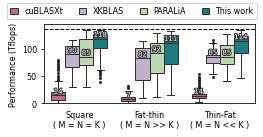

In [8]:
def enforce_dataset_limits(df):
    return df[((df['M']*df['N']*df['K'] >  4096**3))]
    #(df['M']*df['N']*df['K'] <(19457**3))]#248**3)) ] #

sns.set_palette(color_map[1:])
#sns.set_palette(cp3_2)
#sns.color_palette()

dataset_perf_comparisson = dataset[(dataset['imp'] == 'cuBLASXt-float') |
                        (dataset['imp'] == 'XKBLAS-float') |
                        #(dataset['imp'] == 'taco-paralia-1.5-malloc') |
                        (dataset['imp'] == 'taco-paralia-1.5-fixed-streams-float') |
                        #(dataset['imp'] == 'qeta-mineta-auto') |
                        #(dataset['imp'] == 'qeta-auto-reptile') |
                        #(dataset['imp'] == 'qeta-minfetch-auto-reptile')|
                        #dataset['imp'] == 'qeta-mineta-auto-reptile') |
                        (dataset['imp'] == 'qeta-mineta-auto-reptile-float')]
dataset_perf_comparisson['Asloc'][dataset_perf_comparisson['Asloc'] == -2] = -1
dataset_perf_comparisson['Bsloc'][dataset_perf_comparisson['Bsloc'] == -2] = -1
dataset_perf_comparisson['Csloc'][dataset_perf_comparisson['Csloc'] == -2] = -1
dataset_perf_comparisson['loc_str'] = 100*(dataset_perf_comparisson['Csloc']+1) + 10*(dataset_perf_comparisson['Bsloc']+1) + dataset_perf_comparisson['Asloc']+1
dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'cuBLASXt-float'] = 'cuBLASXt'
dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'XKBLAS-float'] = 'XKBLAS'
dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'taco-paralia-1.5-fixed-streams-float'] = 'PARALiA'
dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'qeta-mineta-auto-reptile-float'] = 'This work'

dataset_part_mean = enforce_dataset_limits(PARALiA_grouby_avg(dataset_perf_comparisson))
dataset_part_mean['Performance (Tflops)'] = dataset_part_mean['perf']/1024

#print(dataset_part_mean.head(5))
dataset_plotlist = []
sq_dataset = PARALiA_select_subset(dataset_part_mean,'square')
sq_dataset['shape'] = 'Square\n( M = N = K )'
ft_dataset = PARALiA_select_subset(dataset_part_mean,'fat-thin')
ft_dataset['shape'] = 'Fat-thin\n( M = N >> K )'
tf_dataset = PARALiA_select_subset(dataset_part_mean,'thin-fat')
tf_dataset['shape'] = 'Thin-Fat\n( M = N << K )'
dataset_plotlist = pd.concat([sq_dataset,ft_dataset,tf_dataset] )
#elem_name=['Square ( M = N = K)', 'Fat-thin ( M = N >> K )', 'Thin-fat (M = N << K )']
#dataset_plotlist.append(dataset_part_mean)
flierprops = dict(markerfacecolor='k', markersize=2,
              linestyle='none')
fig, ax = plt.subplots(1,1)
dataset_plotlist.sort_values(inplace = True, by = ['plot_order', 'loc_str'])
axout = sns.boxplot(data=dataset_plotlist, x = 'shape', hue = 'imp', y = 'Performance (Tflops)', ax=ax, flierprops=flierprops)
ax.axhline(y = 17*8, color = 'k', linestyle = '--', linewidth = 1)
ax.set_ylim([0,145])
plt.tick_params(bottom = False) 
add_median_labels(axout, 7)
ax.get_legend().remove()
ax.set_xlabel('')
#ax.set_xticklabels(elem_name, rotation = 15)
fig.legend(loc = 'upper center',#title="Model",  # Title for the legend
    fontsize=font, fancybox = False, ncol=10, handlelength=0.9)
fig.set_size_inches(width, height*0.8)
fig.subplots_adjust(left=.15, bottom=.15/0.8, right=.99, top=1-((1 - .86)/0.8))        
fig.savefig('Plots/Plot_testbed-%s_gflops_expanded_FP32.pdf' % (machine))
fig.savefig('Plots/Plot_testbed-%s_gflops_expanded_FP32.png' % (machine))

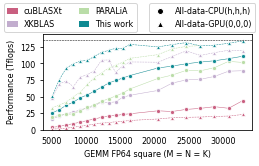

In [9]:
def enforce_gen_dataset_limits(df):
    return df[
    ((df['M']*df['N']*df['K'] >  4096**3)) & 
    #((df['M'] >= 1024)) & ((df['N'] >= 1024)) & ((df['K'] >= 1024)) & 
    (df['M'] == df['N']) & (df['K'] == df['M']) &
    #((df['Asloc'] == -1) |
    (((df['Asloc'] == -1) & (df['Csloc'] == -1)) |
    ((df['Asloc'] == 0) & (df['Bsloc'] == 0) & (df['Csloc'] == 0)))]

sns.set_palette(color_map[1:])
#sns.set_palette(cp3_2)
#sns.color_palette()

dataset_perf_comparisson = dataset[(dataset['imp'] == 'cuBLASXt') |
                        (dataset['imp'] == 'XKBLAS') |
                        #(dataset['imp'] == 'taco-paralia-1.5-malloc') |
                        (dataset['imp'] == 'taco-paralia-1.5-fixed-streams') |
                        #(dataset['imp'] == 'qeta-mineta-auto') |
                        #(dataset['imp'] == 'qeta-auto-reptile') |
                        #(dataset['imp'] == 'qeta-minfetch-auto-reptile')|
                        #dataset['imp'] == 'qeta-mineta-auto-reptile') |
                        (dataset['imp'] == 'qeta-mineta-auto-reptile-fastev')]
dataset_perf_comparisson['Asloc'][dataset_perf_comparisson['Asloc'] == -2] = -1
dataset_perf_comparisson['Bsloc'][dataset_perf_comparisson['Bsloc'] == -2] = -1
dataset_perf_comparisson['Csloc'][dataset_perf_comparisson['Csloc'] == -2] = -1
dataset_perf_comparisson['loc_str'] = 100*(dataset_perf_comparisson['Csloc']+1) + 10*(dataset_perf_comparisson['Bsloc']+1) + dataset_perf_comparisson['Asloc']+1
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'taco-paralia-1.5-fixed-streams'] = 'PARALiA'
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'qeta-mineta-auto-reptile-fastev'] = 'This work'

#dataset_perf_comparisson['imp'][dataset_perf_comparisson['loc_str'] == 0] = dataset_perf_comparisson['imp'] + '(h,h,h)'
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['loc_str'] == 111] = dataset_perf_comparisson['imp'] + '(0,0,0)'

sq_dataset = enforce_gen_dataset_limits(PARALiA_grouby_avg(dataset_perf_comparisson))
sq_dataset['Performance (Tflops)'] = sq_dataset['perf']/1024

implementation_names = ['cuBLASXt', 'XKBLAS', 'PARALiA', 'This work']
#sq_dataset['shape'] = 'Square\n( M = N = K )'
fig, ax = plt.subplots(1,1)
sq_dataset.sort_values(inplace = True, by = ['plot_order'])
#print(sq_dataset)
axout = sns.lineplot(data=sq_dataset[sq_dataset['loc_str'] == 0], x = 'M', y = 'Performance (Tflops)', hue = 'imp', ax=ax, marker = 'o', markersize = 4, linewidth = 0.5)
axout = sns.lineplot(data=sq_dataset[sq_dataset['loc_str'] == 111], x = 'M', y = 'Performance (Tflops)', hue = 'imp', ax=ax , marker = '^', markersize = 4, linewidth = 0.5, linestyle = '--')
ax.get_legend().remove()

# Custom labels, colors, and markers
a_val = 1
circa = []
for ctr in range(0,len(implementation_names)):
    circa.append(matplotlib.patches.Patch(facecolor=color_map[1:][ctr],alpha=a_val,label=implementation_names[ctr]))
fig.legend(handles = circa,
        fontsize=font, loc = 'upper left',  fancybox = True, ncol=2, handlelength=1.3)
    
custom_labels = ['All-data-CPU(h,h,h)', 'All-data-GPU(0,0,0)']
custom_colors = ['k', 'k']
custom_markers = ['o', '^']
# Custom legend elements
legend_elements1 = [matplotlib.lines.Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, label=label, markersize=6)
               for label, color, marker in zip(custom_labels, custom_colors, custom_markers)]
fig.legend(loc = 'upper right', handles=legend_elements1,#bbox_to_anchor=(0.99, 0.81), #title="Speedup",  # Title for the legend
        fontsize=font, fancybox = True, ncol=1)
    
ax.axhline(y = 17*8, color = 'k', linestyle = '--', linewidth = 0.5)
ax.set_ylim([0,145])
plt.tick_params(bottom = False) 
ax.set_xlabel('GEMM FP64 square (M = N = K)')
#ax.set_xticklabels(elem_name, rotation = 15)
fig.set_size_inches(width, height*1.)
fig.subplots_adjust(left=.15, bottom=.18/1., right=.985, top=1-((1 - .8)/1.))        
fig.savefig('Plots/Plot_testbed-%s_gflops_comp_FP64.pdf' % (machine))
fig.savefig('Plots/Plot_testbed-%s_gflops_comp_FP64.png' % (machine))

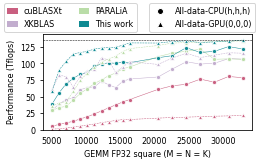

In [10]:
def enforce_gen_dataset_limits(df):
    return df[
    ((df['M']*df['N']*df['K'] >  4096**3)) & 
    #((df['M'] >= 1024)) & ((df['N'] >= 1024)) & ((df['K'] >= 1024)) & 
    (df['M'] == df['N']) & (df['K'] == df['M']) &
    #((df['Asloc'] == -1) |
    (((df['Asloc'] == -1) & (df['Csloc'] == -1)) |
    ((df['Asloc'] == 0) & (df['Bsloc'] == 0) & (df['Csloc'] == 0)))]

sns.set_palette(color_map[1:])
#sns.set_palette(cp3_2)
#sns.color_palette()

dataset_perf_comparisson = dataset[(dataset['imp'] == 'cuBLASXt-float') |
                        (dataset['imp'] == 'XKBLAS-float') |
                        #(dataset['imp'] == 'taco-paralia-1.5-malloc') |
                        (dataset['imp'] == 'taco-paralia-1.5-fixed-streams-float') |
                        #(dataset['imp'] == 'qeta-mineta-auto') |
                        #(dataset['imp'] == 'qeta-auto-reptile') |
                        #(dataset['imp'] == 'qeta-minfetch-auto-reptile')|
                        #dataset['imp'] == 'qeta-mineta-auto-reptile') |
                        (dataset['imp'] == 'qeta-mineta-auto-reptile-float')]
dataset_perf_comparisson['Asloc'][dataset_perf_comparisson['Asloc'] == -2] = -1
dataset_perf_comparisson['Bsloc'][dataset_perf_comparisson['Bsloc'] == -2] = -1
dataset_perf_comparisson['Csloc'][dataset_perf_comparisson['Csloc'] == -2] = -1
dataset_perf_comparisson['loc_str'] = 100*(dataset_perf_comparisson['Csloc']+1) + 10*(dataset_perf_comparisson['Bsloc']+1) + dataset_perf_comparisson['Asloc']+1
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'taco-paralia-1.5-fixed-streams'] = 'PARALiA'
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['imp'] == 'qeta-mineta-auto-reptile-fastev'] = 'This work'

#dataset_perf_comparisson['imp'][dataset_perf_comparisson['loc_str'] == 0] = dataset_perf_comparisson['imp'] + '(h,h,h)'
#dataset_perf_comparisson['imp'][dataset_perf_comparisson['loc_str'] == 111] = dataset_perf_comparisson['imp'] + '(0,0,0)'

sq_dataset = enforce_gen_dataset_limits(PARALiA_grouby_avg(dataset_perf_comparisson))
sq_dataset['Performance (Tflops)'] = sq_dataset['perf']/1024

implementation_names = ['cuBLASXt', 'XKBLAS', 'PARALiA', 'This work']
#sq_dataset['shape'] = 'Square\n( M = N = K )'
fig, ax = plt.subplots(1,1)
sq_dataset.sort_values(inplace = True, by = ['plot_order'])
#print(sq_dataset)
axout = sns.lineplot(data=sq_dataset[sq_dataset['loc_str'] == 0], x = 'M', y = 'Performance (Tflops)', hue = 'imp', ax=ax, marker = 'o', markersize = 4, linewidth = 0.5)
axout = sns.lineplot(data=sq_dataset[sq_dataset['loc_str'] == 111], x = 'M', y = 'Performance (Tflops)', hue = 'imp', ax=ax , marker = '^', markersize = 4, linewidth = 0.5, linestyle = '--')
ax.get_legend().remove()

# Custom labels, colors, and markers
a_val = 1
circa = []
for ctr in range(0,len(implementation_names)):
    circa.append(matplotlib.patches.Patch(facecolor=color_map[1:][ctr],alpha=a_val,label=implementation_names[ctr]))
fig.legend(handles = circa,
        fontsize=font, loc = 'upper left',  fancybox = True, ncol=2, handlelength=1.3)
    
custom_labels = ['All-data-CPU(h,h,h)', 'All-data-GPU(0,0,0)']
custom_colors = ['k', 'k']
custom_markers = ['o', '^']
# Custom legend elements
legend_elements1 = [matplotlib.lines.Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, label=label, markersize=6)
               for label, color, marker in zip(custom_labels, custom_colors, custom_markers)]
fig.legend(loc = 'upper right', handles=legend_elements1,#bbox_to_anchor=(0.99, 0.81), #title="Speedup",  # Title for the legend
        fontsize=font, fancybox = True, ncol=1)
    
ax.axhline(y = 17*8, color = 'k', linestyle = '--', linewidth = 0.5)
ax.set_ylim([0,145])
plt.tick_params(bottom = False) 
ax.set_xlabel('GEMM FP32 square (M = N = K)')
#ax.set_xticklabels(elem_name, rotation = 15)
fig.set_size_inches(width, height*1.)
fig.subplots_adjust(left=.15, bottom=.18/1., right=.985, top=1-((1 - .8)/1.))        
fig.savefig('Plots/Plot_testbed-%s_gflops_comp_FP32.pdf' % (machine))
fig.savefig('Plots/Plot_testbed-%s_gflops_comp_FP32.png' % (machine))